# House Price AI, Revisited

This project is adapted from a prior project, [linked here](https://github.com/RandomKiddo/HousePriceAI), where Scikit-Learn was used on a house price dataset<sup>1</sup> to perform regression to predict the house price value.

I wish to revisit this project using Tensorflow instead of Scikit-Learn so I have more control over the AI itself. Additionally, the old model had an r^2 value of `0.999996824199374`, but that included house location data. I seek to create a model that does not rely on location data. 

In [892]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

We read the data into a Pandas DataFrame<sup>1</sup>.

In [893]:
df = pd.read_csv('data.csv')

In [894]:
df.dtypes

date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object

We see that the only columns that aren't numbers are the data, street, city, statezip, and country columns. Since we don't wish to use location data, and since the date isn't important for our price regression, we can drop all of those columns. In the other model, we enumerated the location data instead. We then manually assert that there are no other columns that aren't `float64` or `int64`.

In [895]:
df = df.drop(['date', 'street', 'city', 'statezip', 'country'], axis=1)

In [896]:
df.dtypes

price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
dtype: object

In [897]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992


We then check for any null values. We see that there are none, but we attempt to drop those values anyway (just in case).

In [898]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
dtype: int64

In [899]:
df = df.dropna()

We then split the data into train and test sets, with 80% bein in the training set.

In [900]:
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

We can describe the training dataset with different metrics like the mean, std, and other values.

In [901]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,3680.0,552674.649108,593696.508031,0.0,322875.00,465000.00,657025.0,26590000.0
bedrooms,3680.0,3.396467,0.911488,0.0,3.00,3.00,4.0,9.0
bathrooms,3680.0,2.162840,0.784678,0.0,1.75,2.25,2.5,8.0
sqft_living,3680.0,2142.219837,966.077603,380.0,1460.00,1980.00,2620.0,13540.0
sqft_lot,3680.0,15220.664402,37480.055461,638.0,5004.50,7700.00,11235.5,1074218.0
floors,3680.0,1.515353,0.534456,1.0,1.00,1.50,2.0,3.5
waterfront,3680.0,0.007880,0.088433,0.0,0.00,0.00,0.0,1.0
view,3680.0,0.235326,0.768751,0.0,0.00,0.00,0.0,4.0
condition,3680.0,3.447554,0.671697,1.0,3.00,3.00,4.0,5.0
sqft_above,3680.0,1836.182065,869.016072,380.0,1190.00,1600.00,2320.0,9410.0


We then split the train and test datasets into the features and the labels, where the labels is the price column (what we wish to predict).

In [902]:
train_features = train_df.copy()
test_features = test_df.copy()
train_labels = train_df.pop('price')
test_labels = test_df.pop('price')

In [903]:
train_df.describe().transpose()[['mean', 'std']]

,mean,std
bedrooms,3.396467,0.911488
bathrooms,2.162840,0.784678
sqft_living,2142.219837,966.077603
sqft_lot,15220.664402,37480.055461
floors,1.515353,0.534456
waterfront,0.007880,0.088433
view,0.235326,0.768751
condition,3.447554,0.671697
sqft_above,1836.182065,869.016072
sqft_basement,306.037772,461.328536


In order to get better results, we should normalize the data. With Tensorflow, we don't need to do this beforehand. We can have the model do it during training using a Normalization layer, adapted to the training features.

In [904]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [905]:
normalizer.adapt(np.array(train_features))

We can see how this normalizer works with examples:

In [906]:
print(normalizer.mean.numpy())

[[5.5267475e+05 3.3964672e+00 2.1628401e+00 2.1422190e+03 1.5220662e+04
  1.5153531e+00 7.8804353e-03 2.3532604e-01 3.4475543e+00 1.8361820e+03
  3.0603769e+02 1.9710018e+03 8.0061859e+02]]


In [907]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[289000.       3.       2.5   2090.    4700.       2.       0.       0.
       3.    2090.       0.    2002.       0. ]]

Normalized: [[-0.44 -0.44  0.43 -0.05 -0.28  0.91 -0.09 -0.31 -0.67  0.29 -0.66  1.04
  -0.82]]


Now we can define the Sequential model. We first put the normalizer so that way the training data is normalized. We then have four Dense layers with 512 filters, ReLU activated, with L2 Regularization (to help overfitting issues I encountered earlier). We then add a standard Dense layer with one filter to finish off the model.

In [908]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1)
])

We compile the model with the Adam optimizer of learning rate 0.001. The loss funciton we are using is mean absolute error, since it is more resistant to outliers compared to mean square error (MSE).

In [909]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

In [910]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_38 (Normaliza  (None, 13)               27        
 tion)                                                           
                                                                 
 dense_121 (Dense)           (None, 512)               7168      
                                                                 
 dense_122 (Dense)           (None, 512)               262656    
                                                                 
 dense_123 (Dense)           (None, 512)               262656    
                                                                 
 dense_124 (Dense)           (None, 512)               262656    
                                                                 
 dense_125 (Dense)           (None, 1)                 513       
                                                     

Fit the model to the training features and labels, with a 20% validation split over 100 epochs.

In [911]:
%%time
history = model.fit(
    train_features, train_labels, validation_split=0.2, epochs=100, verbose=0
)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


CPU times: user 3min 25s, sys: 58.5 s, total: 4min 24s
Wall time: 55.3 s


Plot the loss vs epochs graph.

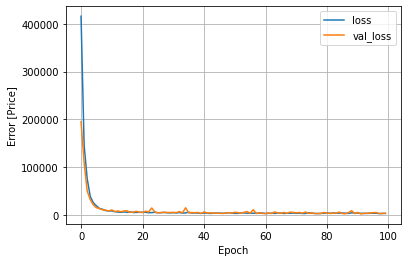

In [912]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [Price]')
plt.legend()
plt.grid(True)

The loss graphs look good. In fact, 100 epochs may have been too much, and the model could likely perform well without needed so many epochs. We can now make predictions on the test features, and compare to the actual test labels.

29/29 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Predictions [Price]')

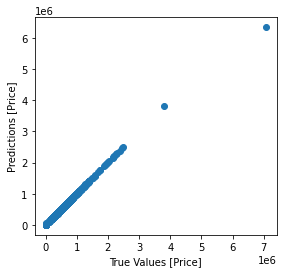

In [913]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')

In [914]:
from sklearn.metrics import r2_score

r2_score(test_labels, test_predictions)

0.9967280624166092

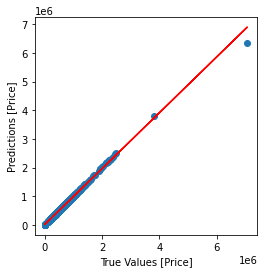

In [917]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
coef = np.polyfit(test_labels, test_predictions, 1)
fn = np.poly1d(coef)
plt.plot(test_labels, fn(test_labels), 'r')

With an r^2 value of `0.9967`, this model performs very well with no location data. It seems that the model does well with values under `4e6`, but the large outlier near `7e6` is not predicted super accurately. However, compared to the rest of the test data, this one data point being slightly inaccurate is fine. 

#### Acknowledgements

<sup>1</sup>Shree. (2018). House Price Prediction. Kaggle. https://www.kaggle.com/datasets/shree1992/housedata

Pandas: https://pandas.pydata.org/docs/ |
Matplotlib: https://matplotlib.org |
Numpy: https://numpy.org |
Tensorflow: https://www.tensorflow.org/

<sub>This project is licensed by the GNU AGPLv3 License</sub>